# QA and Chat over Documents
 
QA and Chat over `Documents` is one of the most popular use-cases for LLMs today.
 
A `Document` is simply a piece of [unstructured data](https://docs.langchain.com/docs/components/schema/document) that can come from any of LangChains's loaders.

You can browser a full list of these loaders in the [integration hub](https://integrations.langchain.com/).

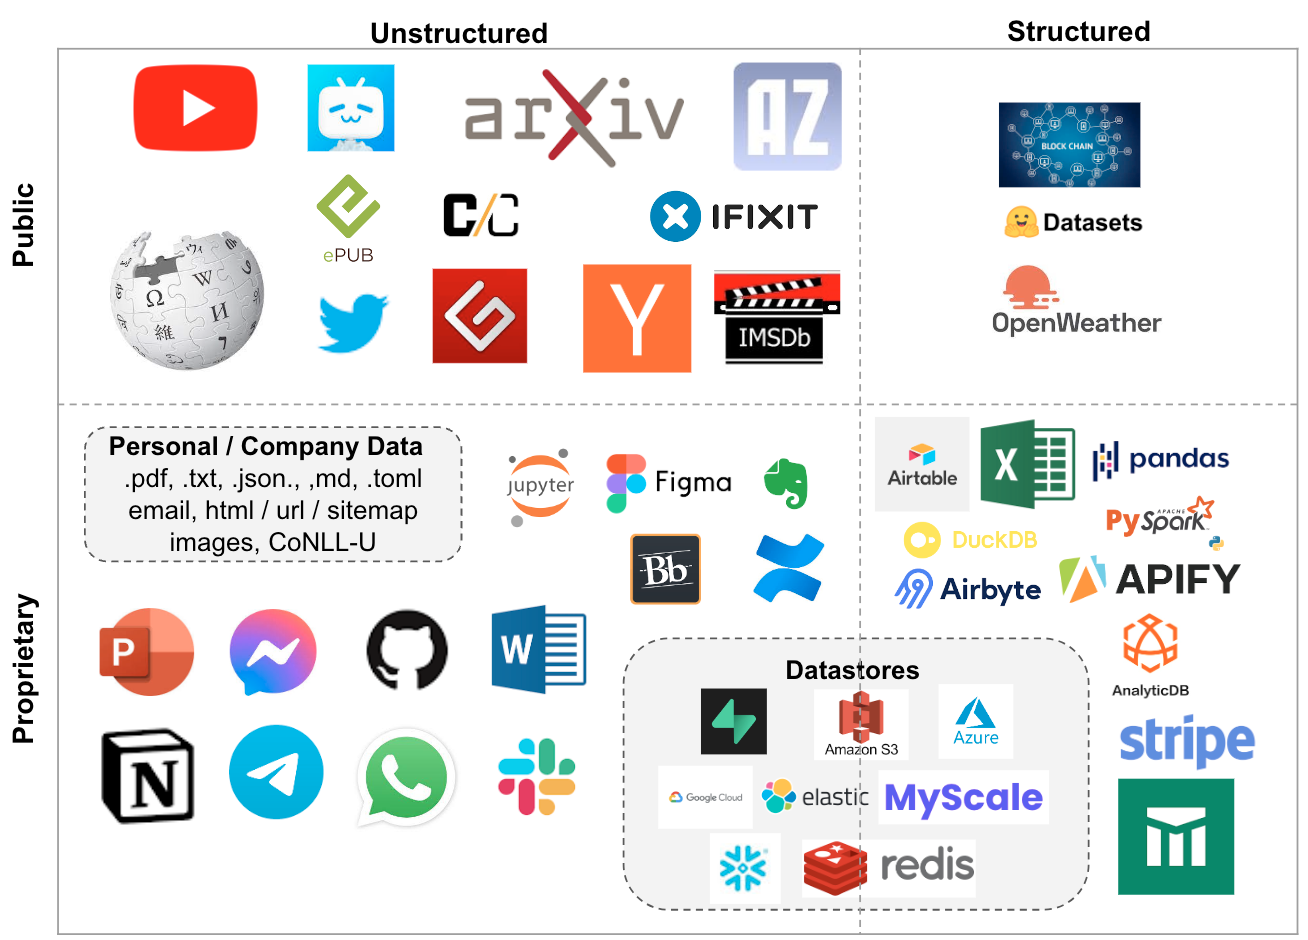

The general flow for QA and Chat follows the steps below, from loading to storing to eventually returning an answer.
 
We will walk throgh each step in detail and how it's easy to enable this in LangChain.

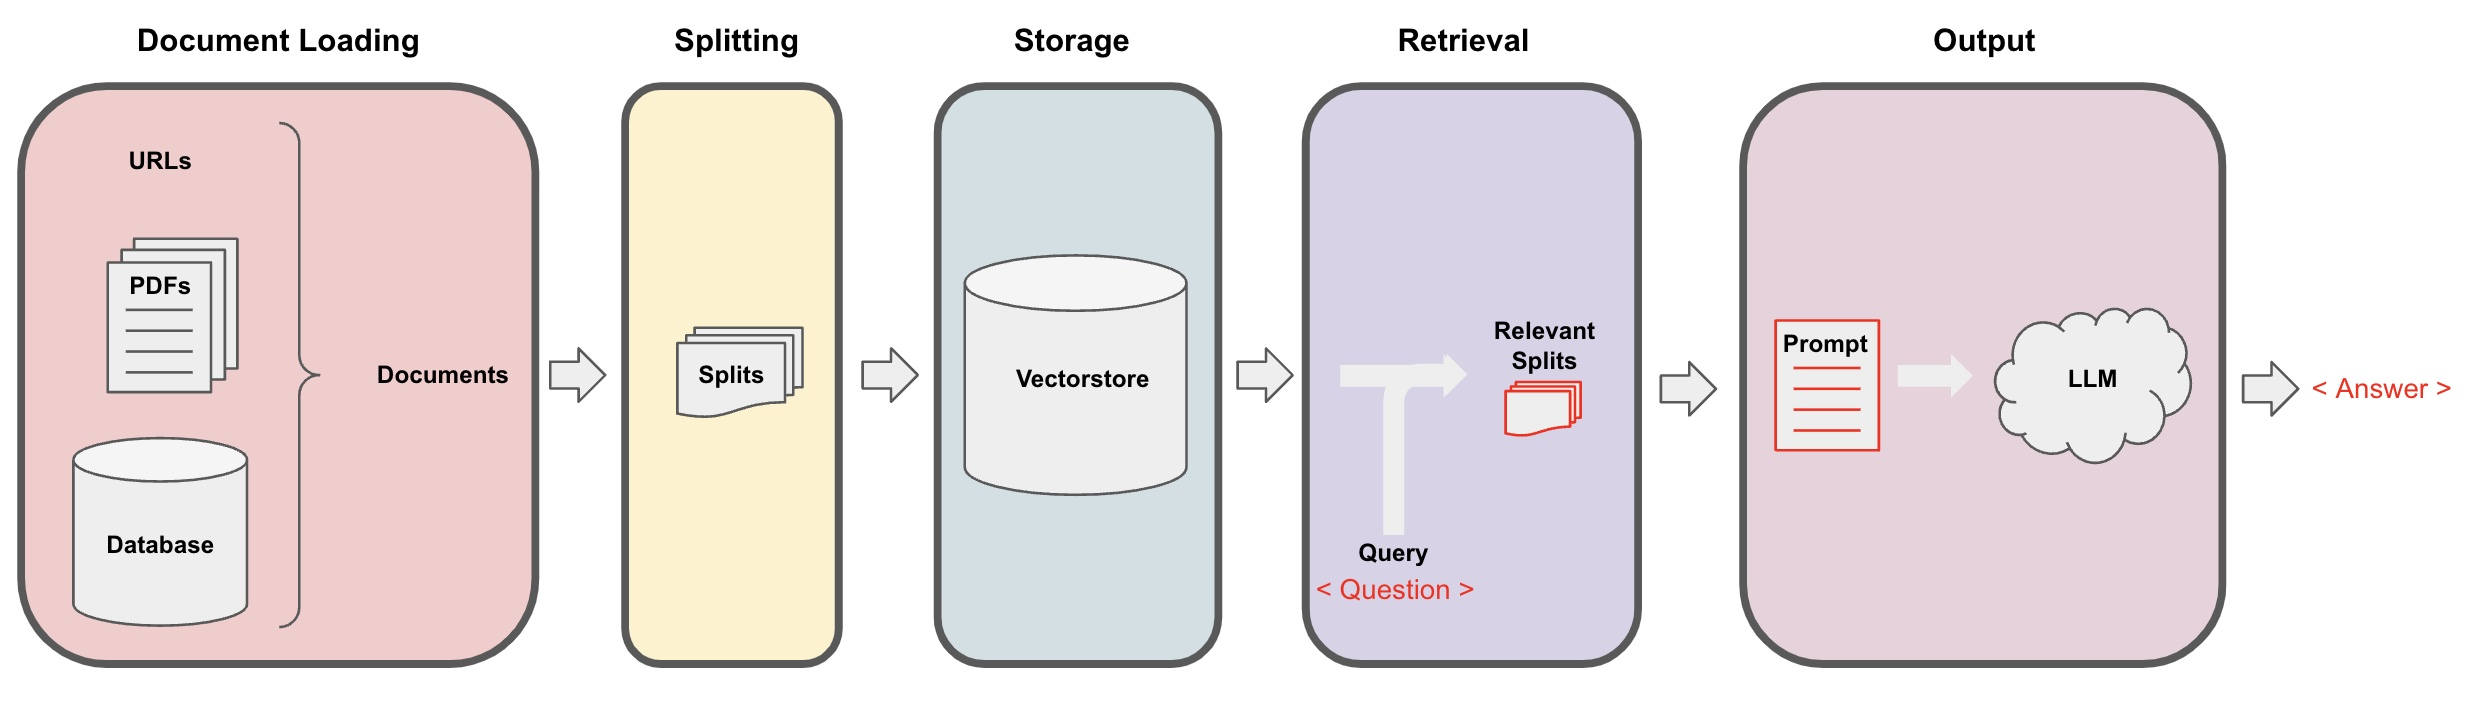

## 1. Loading, Splitting, Storage

### 1.1 Getting started

We'll use this [blog post](https://lilianweng.github.io/posts/2023-06-23-agent/) on Agents as an example document to load.

First, we will load, split, and store the page in [Chroma](https://python.langchain.com/docs/modules/data_connection/vectorstores/integrations/chroma), a vector database.

In [5]:
# Load
from langchain.document_loaders import WebBaseLoader
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

In [2]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
all_splits = text_splitter.split_documents(data)

In [3]:
# Store 
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
vectorstore = Chroma.from_documents(documents=all_splits,embedding=OpenAIEmbeddings())

### 1.2 Going Deeper

#### 1.2.1 Integrations

There are > 120 different data loader integrations!

You can browser them easily [here](https://integrations.langchain.com/).

In general, all will load `Documents` as we saw above with `data = loader.load()`.

Then, `Documents` can be transformed (typically into chunks for storage), as shown above, by a `text_splitter`.
 
#### 1.2.2 Retaining metadata

We may want to retain context about where each chunk came from in the source docuent.

We can do this using varioud "context-aware" splitters:

* [Markdown files](https://python.langchain.com/docs/use_cases/question_answering/document-context-aware-QA)
* [Code (py or js)](https://python.langchain.com/docs/modules/data_connection/document_loaders/integrations/source_code):
* [Documents](https://python.langchain.com/docs/modules/data_connection/document_loaders/integrations/grobid)

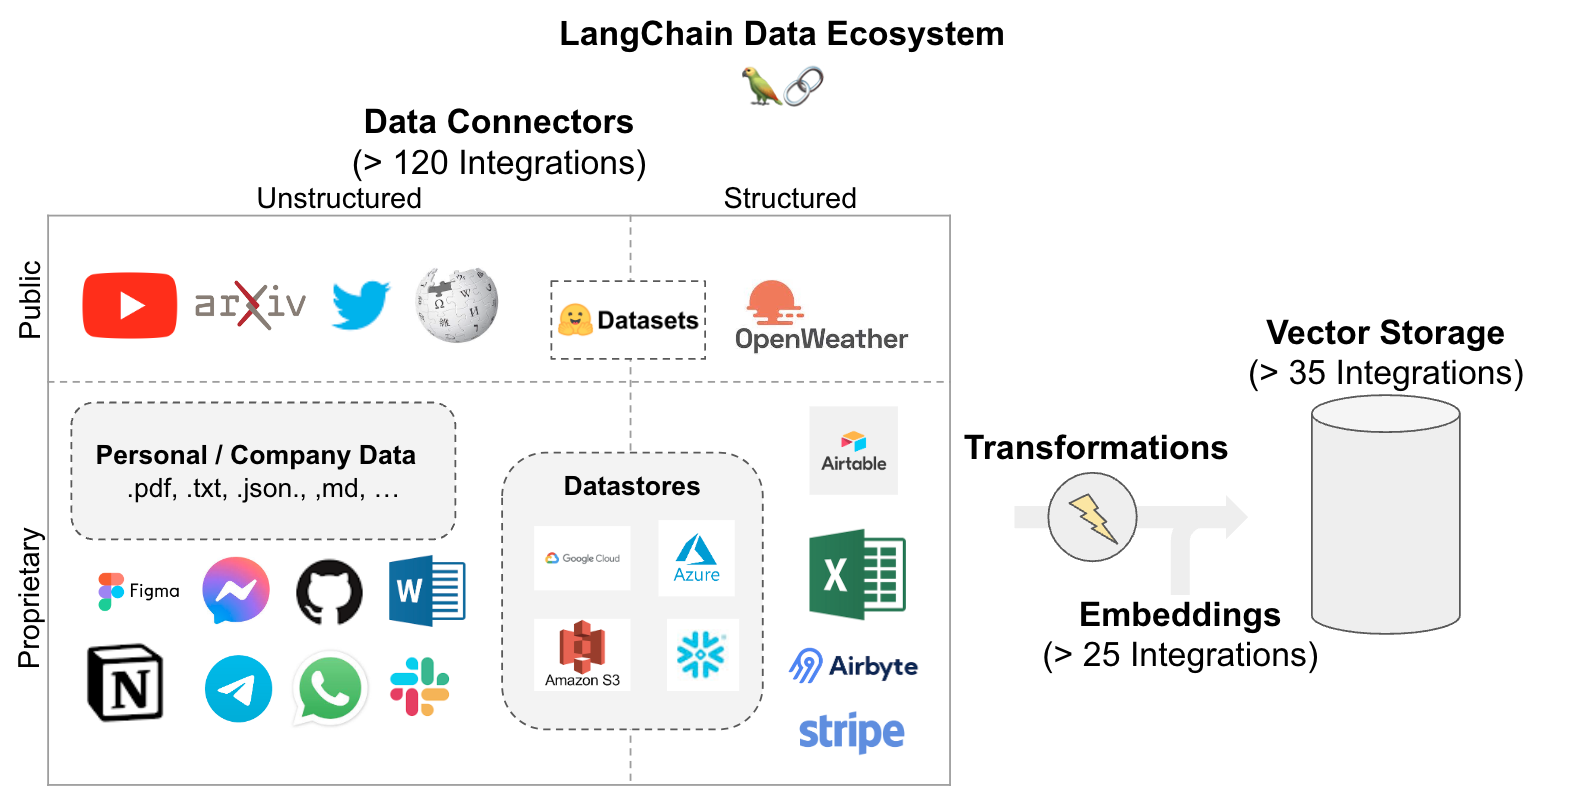

## 2. Retrieval 

### 2.1 Similarity Search

With documents split and stored in `Chroma`, we can query for a specific questions.
 
We embed (represent) the queries in high-dimensional space and find similar embedded documents based on "distance". 

In [6]:
question = "What are the approaches to Task Decomposition?"
docs = vectorstore.similarity_search(question,k=3)
len(docs)

3

### 2.2 Going Deeper

#### More advanced retrieval

Several different ideas can be used to improve document retrieval:

* We can use `MultiQueryRetriever` to improve returned documents by [modifying the input question](https://python.langchain.com/docs/modules/data_connection/retrievers/how_to/MultiQueryRetriever), shown below.

* We can use `max marginal relevance` to achieve both [relevance to the query and diversity](https://www.cs.cmu.edu/~jgc/publication/The_Use_MMR_Diversity_Based_LTMIR_1998.pdf) among the returned documents.

* We can query based on [specific `metadata`](https://python.langchain.com/docs/use_cases/question_answering/document-context-aware-QA) using metadata filters.

In [9]:
# MultiQueryRetriever
import logging
from langchain.chat_models import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever
logging.basicConfig()
logging.getLogger('langchain.retrievers.multi_query').setLevel(logging.INFO)
retriever_from_llm = MultiQueryRetriever.from_llm(retriever=vectorstore.as_retriever(),
                                                  llm=ChatOpenAI(temperature=0))
unique_docs = retriever_from_llm.get_relevant_documents(query=question)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. How can Task Decomposition be approached?', '2. What are the different methods for Task Decomposition?', '3. What are the various approaches to decomposing tasks?']


5

## 3. RetrievalQA

### 3.1 Getting started

Now, we want to take these retrieved docs and distill them into an answer to our question.
 
We can pipe together:

* The retrieved docs from the `vectorstore`
* An `LLM` to summarize them into an answer to our question

For the `LLM`, we use OpenAI (e.g., `gpt-3.5-turbo`).

In [18]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectorstore.as_retriever())
qa_chain({"query": question})

{'query': 'What are the approaches to Task Decomposition?',
 'result': 'The approaches to task decomposition include:\n\n1. Simple prompting: This approach involves using simple prompts or questions to guide the agent in breaking down a task into smaller subgoals. For example, the agent can be prompted with "Steps for XYZ" and asked to list the subgoals for achieving XYZ.\n\n2. Task-specific instructions: In this approach, task-specific instructions are provided to the agent to guide the decomposition process. For example, if the task is to write a novel, the agent can be instructed to "Write a story outline" as a subgoal.\n\n3. Human inputs: This approach involves incorporating human inputs in the task decomposition process. Humans can provide guidance, feedback, and suggestions to help the agent break down complex tasks into manageable subgoals.\n\nThese approaches aim to enable efficient handling of complex tasks by breaking them down into smaller, more manageable subgoals.'}

### 3.2 Going Deeper

#### 3.2.1 Running locally

The popularity of [PrivateGPT](https://github.com/imartinez/privateGPT) and [GPT4All](https://github.com/nomic-ai/gpt4all) underscore the importance of running LLMs locally.

LangChain has integrations with numerous open source models that can be run locally.

In particular, [the LangChain integration hub](https://integrations.langchain.com/) shows the popularity of GPT4All. 

Once we follow [these steps](https://python.langchain.com/docs/modules/model_io/models/llms/integrations/gpt4all) to download the model, running it is as simple as what we shown below.

In particular, we simply swap out the `llm` argument!

In [ ]:
from langchain.llms import GPT4All
from langchain.chains import RetrievalQA
llm = GPT4All(model="/Users/rlm/Desktop/Code/gpt4all/models/nous-hermes-13b.ggmlv3.q4_0.bin",max_tokens=2048)
qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectorstore.as_retriever())
qa_chain({"query": question})

#### 3.2.2. Custom prompt

Many user also want to know how to modify the prompt in retrievalQA.

This is easy to to do.

In [20]:
# Build prompt
from langchain.prompts import PromptTemplate
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

# Run chain
from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectorstore.as_retriever(),
                                       return_source_documents=True,
                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})

result = qa_chain({"query": question})
result["result"]

'Task decomposition can be done by LLM with simple prompting, task-specific instructions, or with human inputs. Thanks for asking!'

## 4. Chat

### 4.1 Getting started

RetrievalQA does not keep chat history, so we need a few new ideas:

(1) Specify a `Memory buffer`
 
 * This is neccessary to track the inputs/outputs and hold a conversation.

In [21]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

In [22]:
from langchain.chains import ConversationalRetrievalChain
retriever=vectorstore.as_retriever()
chat = ConversationalRetrievalChain.from_llm(llm,retriever=retriever,memory=memory)

(2) Use a `ConversationalRetrievalChain`

* Chat history is retrieved from the provided memory.

In [25]:
result = chat({"question": "What are some of the main ideas in self-reflection?"})
result['answer']

"The main concepts or principles involved in self-reflection include:\n\n1. Iterative Improvement: Self-reflection allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It involves analyzing and learning from past experiences to make better decisions in the future.\n\n2. Trial and Error: Self-reflection plays a crucial role in real-world tasks where trial and error are inevitable. By reflecting on failed trajectories and ideal reflections, agents can learn from their mistakes and adjust their actions accordingly.\n\n3. Two-Shot Examples: Self-reflection is created by showing two-shot examples to the agent. Each example consists of a failed trajectory (a sequence of actions that led to an undesirable outcome) and an ideal reflection (guidance for future changes in the plan). These examples serve as a basis for the agent to learn and improve its reasoning skills.\n\n4. Working Memory: Reflections obtained from the two-shot exa

The memory buffer retains histoy, so context for "it" in the question is resolved.

In [26]:
result = chat({"question": "How does the Reflexion paper handle it?"})
result['answer']

"The Reflexion paper handles self-reflection by showing two-shot examples to the Learning Language Model (LLM). Each example consists of a failed trajectory and an ideal reflection that guides future changes in the agent's plan. These reflections are then added to the agent's working memory, up to a maximum of three, to be used as context for querying the LLM."

### 4.2 Going deeper

The [documentation](https://python.langchain.com/docs/modules/chains/popular/chat_vector_db) on `ConversationalRetrievalChain` offers a few extensions:

* Streaming
* Returning the retrieved documents

## 5. Conclusion

For more options across this workflow, see the [LangChain integration hub](https://integrations.langchain.com/).